________

# VAE LSTM for anomalies detection in AAPL stock market data

## Exploratory Data Analysis (EDA) and Variable Selection

To begin with, we'll perfom an Exploratory Data Analysis (EDA) to understand the characteristics of the AAPL stock market dataset. This dataset was obtained from Yahoo Finance and contains the daily stock prices of Apple Inc. from 1990 to 2023.

### Summary of the dataset

The dataset consists of:
- Date: The date of the record
- Open: The opening price of the stock
- High: The highest price during the day
- Low: The lowest price during the day
- Close: The closing price of the stock
- Adj Close: The adjusted closing price
- Volume: the number of shares traded

### Basic analysis

For the basic analysis, we will proceed checking the distributions of the variables, the correlation between them, and the presence of missing values.

In [177]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Load the dataset
file_path = 'AAPL.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the dataset
print(data.head())
print(data.info())
print(data.describe())

# Convert 'Date' column to datetime
data['Date'] = pd.to_datetime(data['Date'])

         Date      Open      High       Low     Close  Adj Close     Volume
0  1990-01-02  0.314732  0.334821  0.312500  0.332589   0.262722  183198400
1  1990-01-03  0.339286  0.339286  0.334821  0.334821   0.264485  207995200
2  1990-01-04  0.341518  0.345982  0.332589  0.335938   0.265367  221513600
3  1990-01-05  0.337054  0.341518  0.330357  0.337054   0.266249  123312000
4  1990-01-08  0.334821  0.339286  0.330357  0.339286   0.268012  101572800
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8565 entries, 0 to 8564
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       8565 non-null   object 
 1   Open       8565 non-null   float64
 2   High       8565 non-null   float64
 3   Low        8565 non-null   float64
 4   Close      8565 non-null   float64
 5   Adj Close  8565 non-null   float64
 6   Volume     8565 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 468.5+ KB
None
         

The dataset shows no missing values and presents a comprehensive set of statistics, which indicates that the data is clean and ready for further processing.

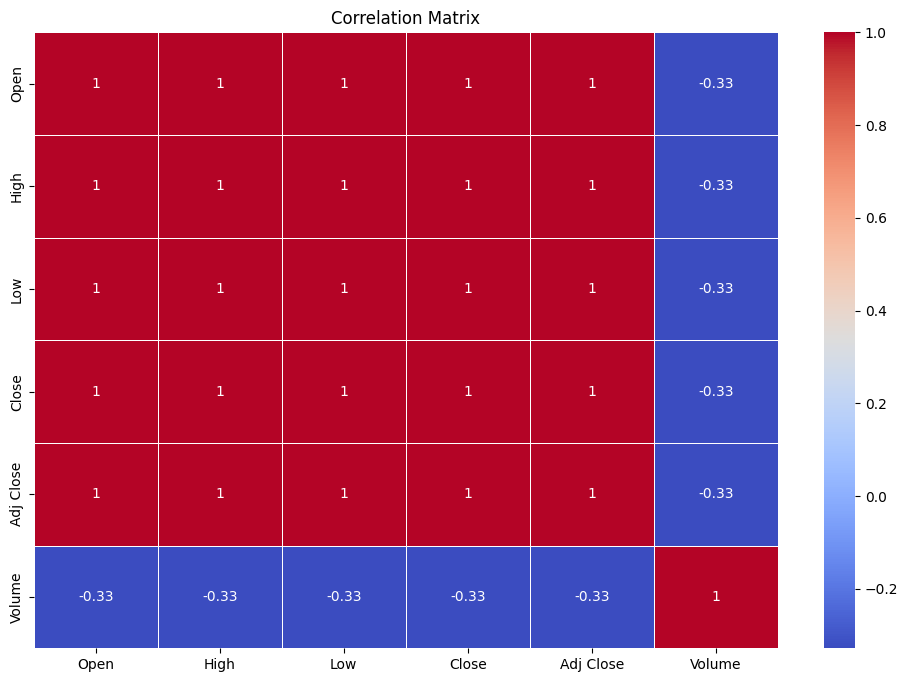

In [180]:
# Correlation matrix
correlation_matrix = data.corr()

# Plot the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()


From the correlation matrix, we can see that:

- There is an high correlation between `Close` and `Adj Close` prices, which is expected since as the adjusted close price is derived from the close price asjusted for dividends and stock splits.
- Other price related features like `Open`, `High`, `Low` and `Close` are also highly correlated, which males sense given they represent prices withing the same day.
- Volume has a lower correlation with price features, indicating it might provide additional information.

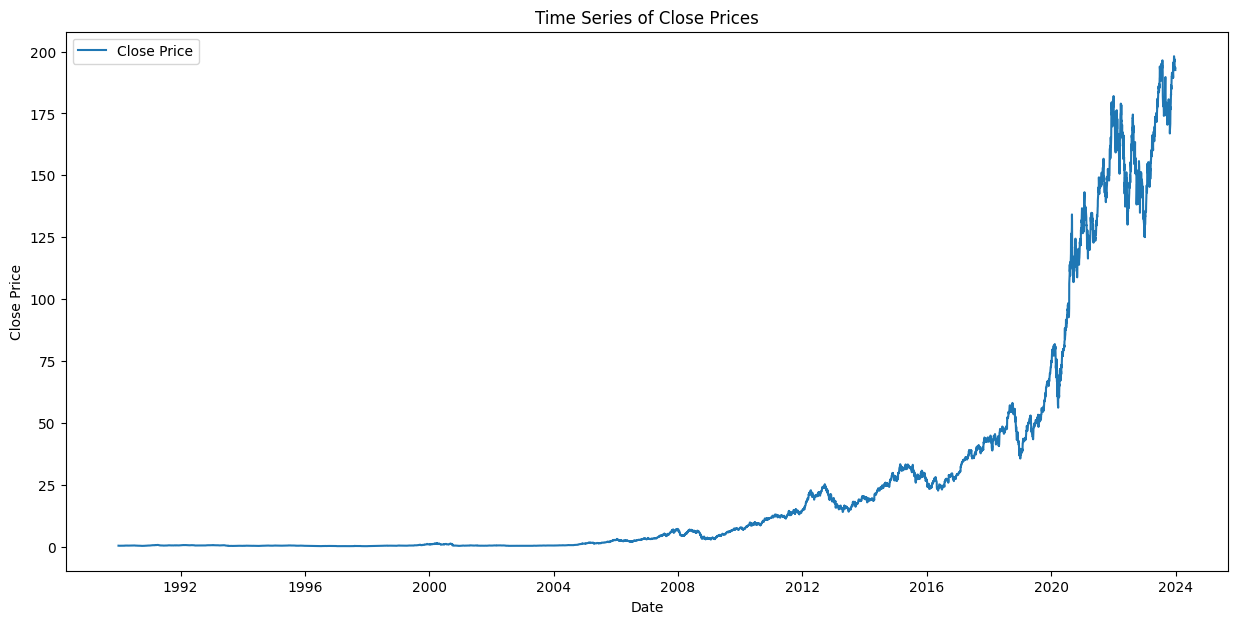

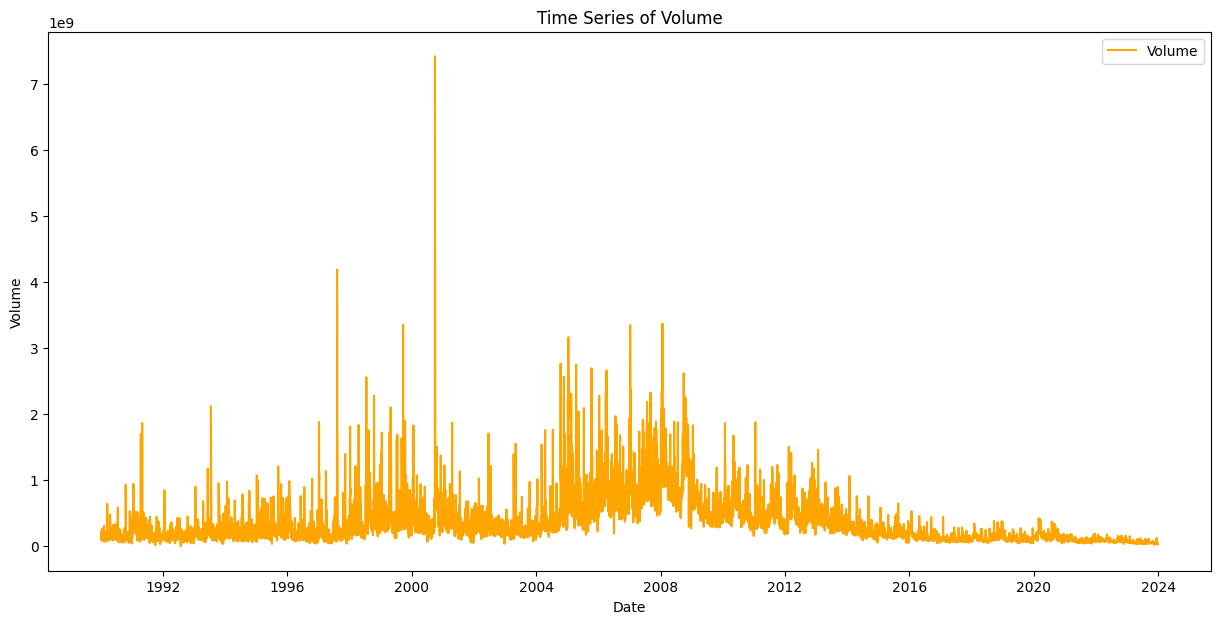

In [178]:
# Plot the time series data for 'Close' prices
plt.figure(figsize=(15, 7))
plt.plot(data['Date'], data['Close'], label='Close Price')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Time Series of Close Prices')
plt.legend()
plt.show()

# Plot the time series data for 'Volume'
plt.figure(figsize=(15, 7))
plt.plot(data['Date'], data['Volume'], label='Volume', color='orange')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.title('Time Series of Volume')
plt.legend()
plt.show()


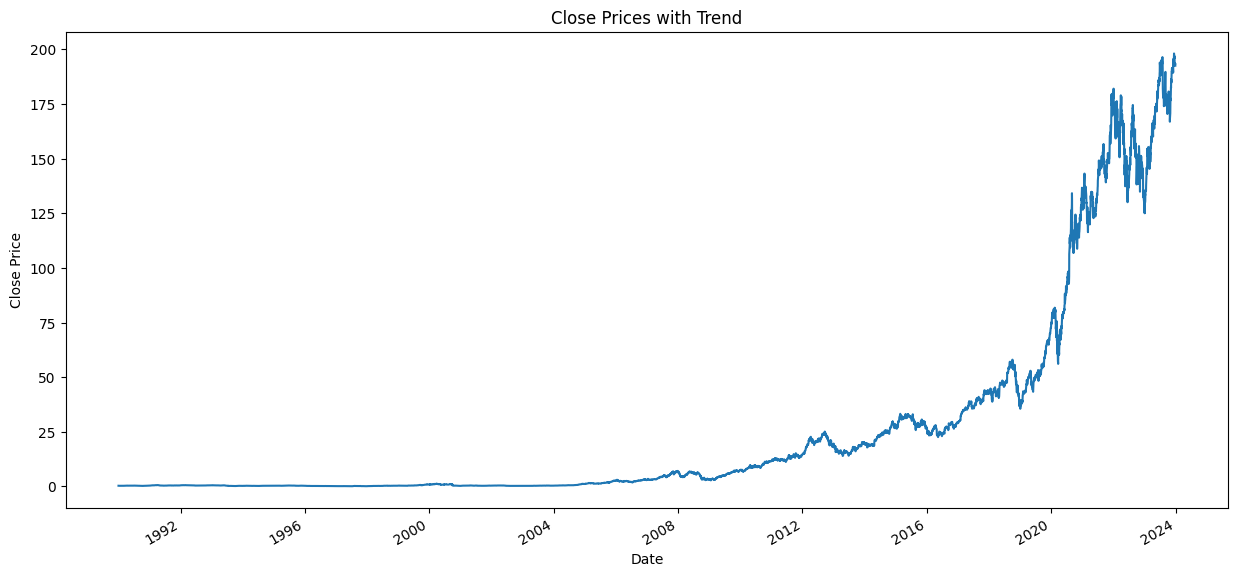

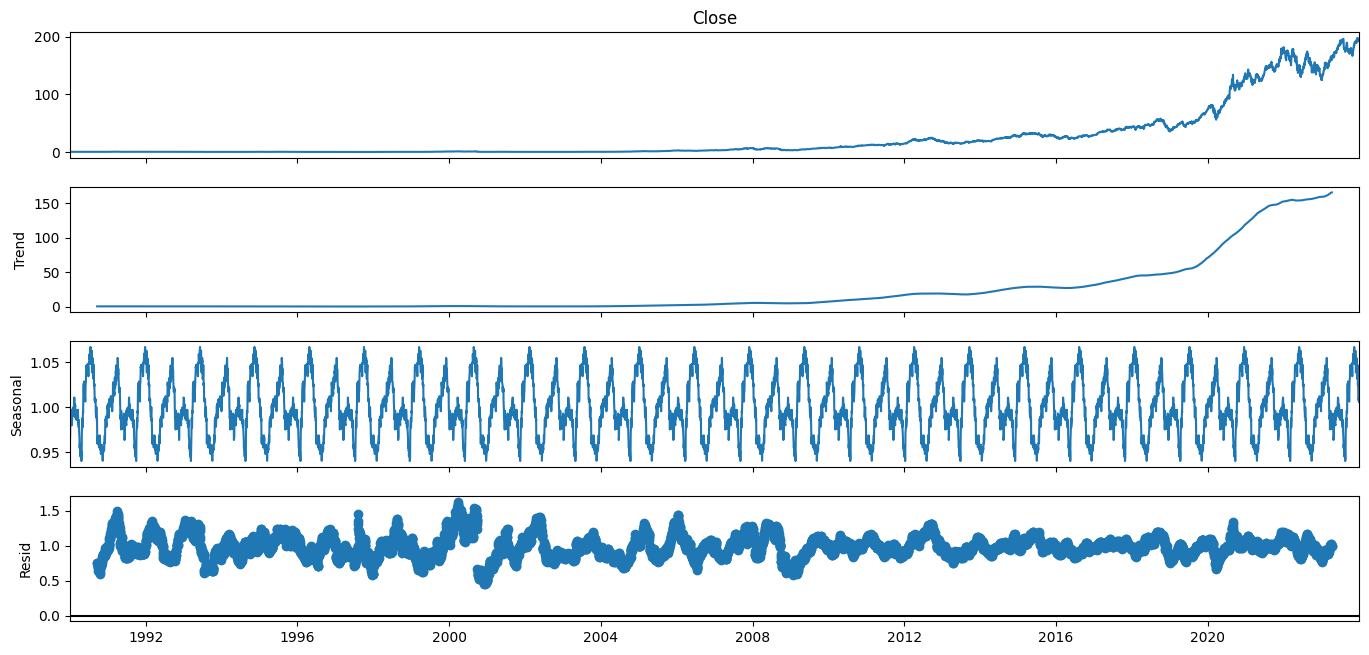

In [179]:
# Check for trends and seasonality in the 'Close' prices
data.set_index('Date', inplace=True)
data['Close'].plot(figsize=(15, 7), title='Close Prices with Trend')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()

# Decompose the time series to observe trend, seasonality, and residuals
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(data['Close'], model='multiplicative', period=365)
fig = result.plot()
fig.set_size_inches(15, 7)
plt.show()


**Close Price Trends**
The "Close Price" shows a significant upward trend, especially from 2010 onwards. The growth is exponential in recent years.
The exponential growth suggests that the data is highly non-stationary, which is a critical factor to consider for time series modeling.

**Volume Trends**
The trading volume has high variability with some extreme spikes around 2000.
There is a general decline in volume over time, which might be due to stock splits or changes in market conditions.

**Seasonality and Decomposition**
The seasonal decomposition of the "Close" prices indicates clear seasonal patterns.
The trend component shows the overall upward movement, while the seasonal component captures regular fluctuations.

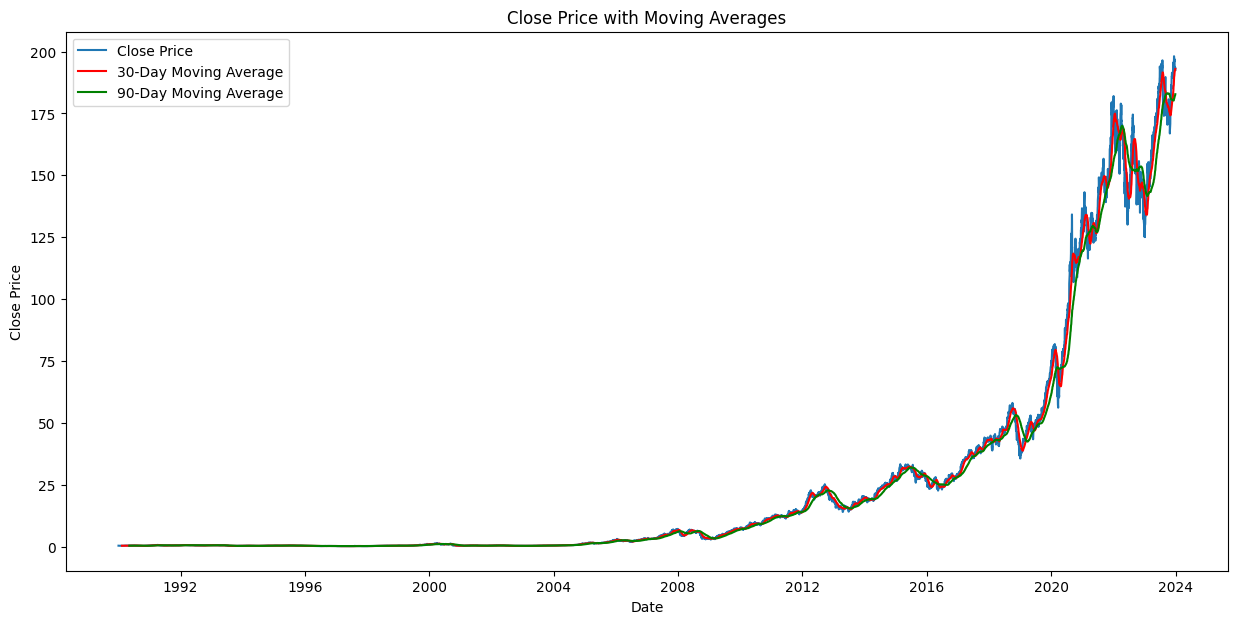

In [181]:
# Calculate moving averages
data['Close_MA30'] = data['Close'].rolling(window=30).mean()
data['Close_MA90'] = data['Close'].rolling(window=90).mean()

# Plot the moving averages along with the original 'Close' prices
plt.figure(figsize=(15, 7))
plt.plot(data['Close'], label='Close Price')
plt.plot(data['Close_MA30'], label='30-Day Moving Average', color='red')
plt.plot(data['Close_MA90'], label='90-Day Moving Average', color='green')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Close Price with Moving Averages')
plt.legend()
plt.show()

The 30-day and 90-day moving averages follow the trend of the close prices closely, indicating that these averages can help smooth out the short-term fluctuations and reveal the underlying trend.

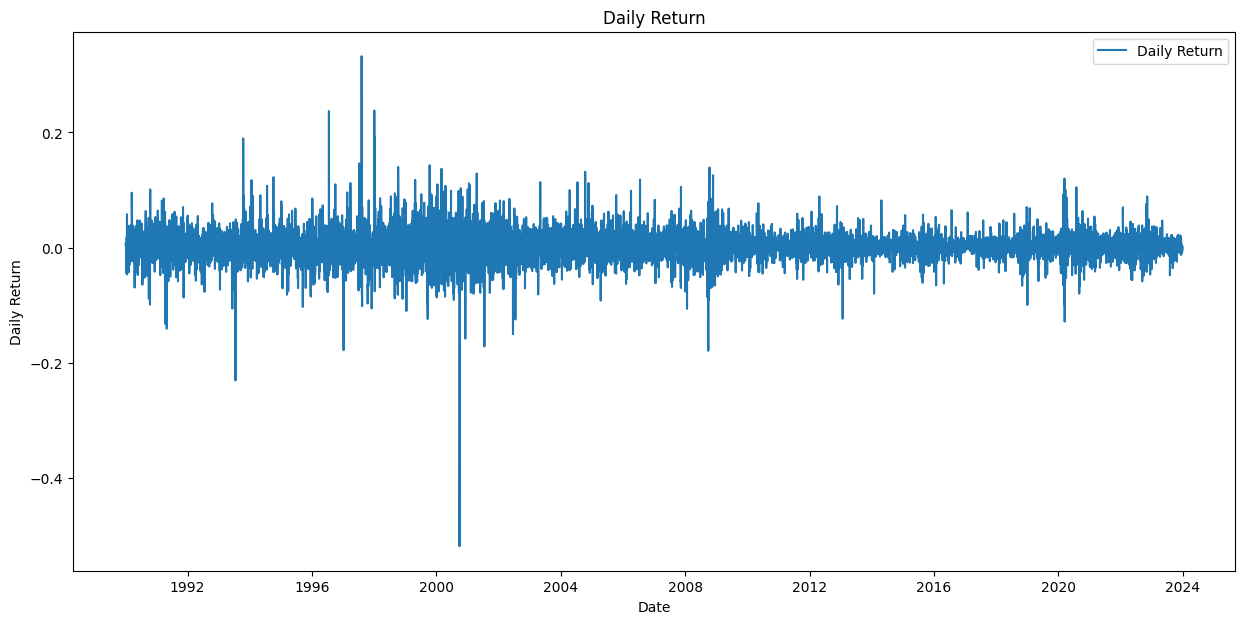

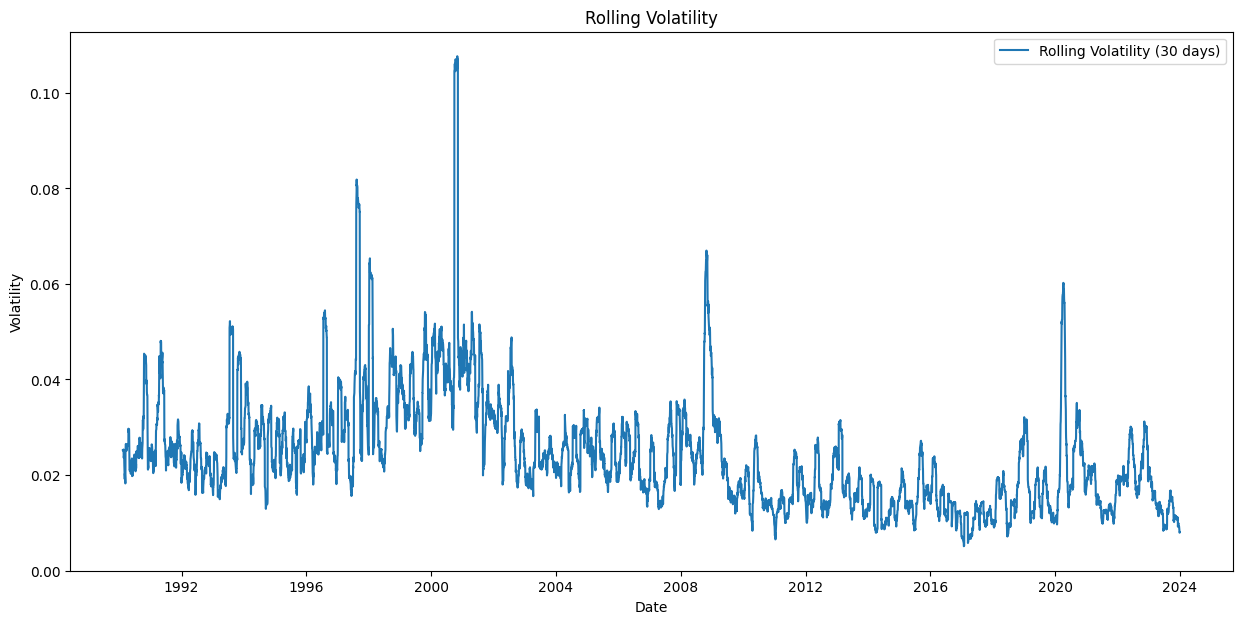

In [182]:
# Calculate daily returns
data['Daily_Return'] = data['Close'].pct_change() # Calculate the percentage change of the 'Close' prices

# Plot the daily returns
plt.figure(figsize=(15, 7))
plt.plot(data['Daily_Return'], label='Daily Return')
plt.xlabel('Date')
plt.ylabel('Daily Return')
plt.title('Daily Return')
plt.legend()
plt.show()

# Plot the rolling volatility (standard deviation of daily returns)
data['Volatility'] = data['Daily_Return'].rolling(window=30).std()

plt.figure(figsize=(15, 7))
plt.plot(data['Volatility'], label='Rolling Volatility (30 days)')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.title('Rolling Volatility')
plt.legend()
plt.show()

The daily return plot shows high volatility, with significant spikes during certain periods, especially around the dot-com bubble (2000) and the 2008 financial crisis.
The volatility appears to have reduced in recent years but still shows significant fluctuations during market events like the COVID-19 pandemic.

The rolling volatility plot shows periods of high and low volatility, with notable spikes around major market events.
This plot can help us understand the market dynamics and the periods when the stock experienced significant price changes.

## Data Preprocessing

Once we have selected the features, we will proceed with the data preprocessing steps, which include:

- Normalizing the data to ensure it is suitable for training the VAE-LSTM model
- Creating sequences suitable for time series analysis.

In [34]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [90]:
# Load the data
data = pd.read_csv('AAPL.csv')  

# Select the relevant columns
data_selected = data[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']]

# Convert Date column to datetime format
data_selected.loc[:, 'Date'] = pd.to_datetime(data_selected['Date'])

# Sort by date
data_selected = data_selected.sort_values('Date')

# Set Date as index
data_selected.set_index('Date', inplace=True)

# Normalize the data
scaler = MinMaxScaler()
data_normalized = scaler.fit_transform(data_selected)

# Convert normalized data back to DataFrame
data_normalized = pd.DataFrame(data_normalized, columns=data_selected.columns, index=data_selected.index)

data_normalized.head()

,Open,High,Low,Close,Volume
Date,,,,,
1990-01-02,0.001009,0.001085,0.001009,0.001096,0.024369
1990-01-03,0.001134,0.001108,0.001122,0.001108,0.027712
1990-01-04,0.001145,0.001141,0.001111,0.001113,0.029534
1990-01-05,0.001122,0.001119,0.001100,0.001119,0.016298
1990-01-08,0.001111,0.001108,0.001100,0.001130,0.013367


We have successfully:
- Converted the `Date` column to a datetime format and set it as the index;
- Normalized the data using `MinMaxScaler` to ensure that the features are on a similar scale.


### Creating Sequences for Time Series Analysis

For the VAE-LSTM model, we need to create sequences of a fixed length. This involves creating overlapping windows of data that the model can use to learn temporal patterns.

So, it will be necessary to define a function to create these sequences. For example, with a windows size of 60 (representing 60 days market data), the model will use the past 60 days to predict the next day. 

In [91]:
def create_sequences(data, seq_length):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        seq = data[i:i + seq_length]
        label = data[i + seq_length]
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

# Define sequence length
sequence_length = 60

# Create sequences
X, y = create_sequences(data_normalized.values, sequence_length)

# Print the shape of the sequences
X.shape, y.shape

((8505, 60, 5), (8505, 5))

- $X$ (features) shape (number of samples, window size, number of features): $(8505, 60, 5)$
- $y$ (labels) shape (number of samples, number of features): $(8505, 5)$

This means that we have 8505 sequences, each with a length of 60 time steps and 5 features.

## Model Building - VAE-LSTM Model

Now it's the turn to build a Variational Autoencoder (VAE) with LSTM (Long-Short Term Memory) layers using PyTorch. The VAE will consist of an encoder that compresses the input sequences into a latent space and a decoder that reconstructs the sequences from the latent space.

**Model Components**: 
- Encoder:
    - Uses an LSTM to process the input sequence.
    - The final hidden state of the LSTM is used to parameterize the latent space.
- Latent Space:
    - Consists of two fully connected layers that output the mean (mu) and log-variance (logvar) of the latent distribution.
- Decoder:
    - Uses another LSTM to reconstruct the sequence from the latent representation.
    - A final fully connected layer maps the LSTM output back to the original input dimensions.

**Model Architecture Details**: 
- init method:
    - Initializes the encoder LSTM, latent space fully connected layers, decoder LSTM, and output layer.
- encode method:
    - Processes the input sequence through the encoder LSTM.
    - Maps the final hidden state to mu and logvar of the latent space.
- reparameterize method:
    - Implements the reparameterization trick, allowing backpropagation through the sampling process.
    - Samples from the latent distribution using mu and logvar.
- decode method:
    - Repeats the latent vector for each time step in the sequence.
    - Processes this through the decoder LSTM and output layer to reconstruct the sequence.
- forward method:
    - Combines encode, reparameterize, and decode to process input data through the entire model.

**Model Parameters**:
input_dim = 5: Number of features in each time step of the input sequence.
hidden_dim = 128: Dimension of the LSTM hidden state.
latent_dim = 3: Dimension of the latent space.
seq_length = 60: Number of time steps in each input sequence.

**Loss Function**:
- Combines reconstruction loss (MSE between input and reconstruction) and KL divergence.
- KL divergence encourages the latent distribution to be close to a standard normal distribution.

**Optimizer**:
- Uses Adam optimizer with a learning rate of 0.001.


In [92]:
import torch
import torch.nn as nn
import torch.optim as optim

class VAELSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, seq_length):
        super(VAELSTM, self).__init__()
        self.seq_length = seq_length
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        
        # Encoder LSTM
        self.encoder_lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        
        # Latent space
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        
        # Decoder LSTM
        self.decoder_lstm = nn.LSTM(latent_dim, hidden_dim, batch_first=True)
        self.fc_out = nn.Linear(hidden_dim, input_dim)
        
    def encode(self, x):
        _, (hn, _) = self.encoder_lstm(x)
        hn = hn.view(-1, self.hidden_dim)
        mu = self.fc_mu(hn)
        logvar = self.fc_logvar(hn)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        z = z.unsqueeze(1).repeat(1, self.seq_length, 1)
        lstm_out, _ = self.decoder_lstm(z)
        recon_x = self.fc_out(lstm_out)
        return recon_x
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z)
        return recon_x, mu, logvar

# Define the model parameters
input_dim = 5  # Number of input features
hidden_dim = 128  # Hidden dimension of LSTM
latent_dim = 3  # Latent dimension
seq_length = 60  # Sequence length

# Initialize the model
model = VAELSTM(input_dim, hidden_dim, latent_dim, seq_length)

# Define the optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)

def loss_function(recon_x, x, mu, logvar):
    # Reconstruction loss
    recon_loss = nn.MSELoss()(recon_x, x)
    # KL Divergence
    kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kld

model

VAELSTM(
  (encoder_lstm): LSTM(5, 128, batch_first=True)
  (fc_mu): Linear(in_features=128, out_features=3, bias=True)
  (fc_logvar): Linear(in_features=128, out_features=3, bias=True)
  (decoder_lstm): LSTM(3, 128, batch_first=True)
  (fc_out): Linear(in_features=128, out_features=5, bias=True)
)

### Training the VAE-LSTM Model

Data is split into training and validation sets, converted to PyTorch tensors. The model is trained over multiple epochs, where for each epoch, the model parameters are updated to minimize the loss calculated from the reconstructed outputs. Validation is performed by evaluating the model with the held-out data. Losses (both training and validation) are plotted against epochs to visualize learning progress and overfitting.

Epoch 1, Loss: 48.0888557434082, Val Loss: 7.438316822052002
Epoch 2, Loss: 29.860776901245117, Val Loss: 4.115755081176758
Epoch 3, Loss: 16.477487564086914, Val Loss: 1.9288151264190674
Epoch 4, Loss: 7.6655144691467285, Val Loss: 0.7862718105316162
Epoch 5, Loss: 3.0527918338775635, Val Loss: 0.4962333142757416
Epoch 6, Loss: 1.8726060390472412, Val Loss: 0.7238717675209045
Epoch 7, Loss: 2.778813123703003, Val Loss: 1.0629676580429077
Epoch 8, Loss: 4.1397247314453125, Val Loss: 1.2424495220184326
Epoch 9, Loss: 4.862415313720703, Val Loss: 1.206424355506897
Epoch 10, Loss: 4.71952486038208, Val Loss: 1.0273154973983765
Epoch 11, Loss: 4.002203941345215, Val Loss: 0.8024498820304871
Epoch 12, Loss: 3.098619222640991, Val Loss: 0.5987573266029358
Epoch 13, Loss: 2.280808210372925, Val Loss: 0.44542819261550903
Epoch 14, Loss: 1.665873646736145, Val Loss: 0.34388259053230286
Epoch 15, Loss: 1.2595795392990112, Val Loss: 0.28252795338630676
Epoch 16, Loss: 1.0139259099960327, Val Loss

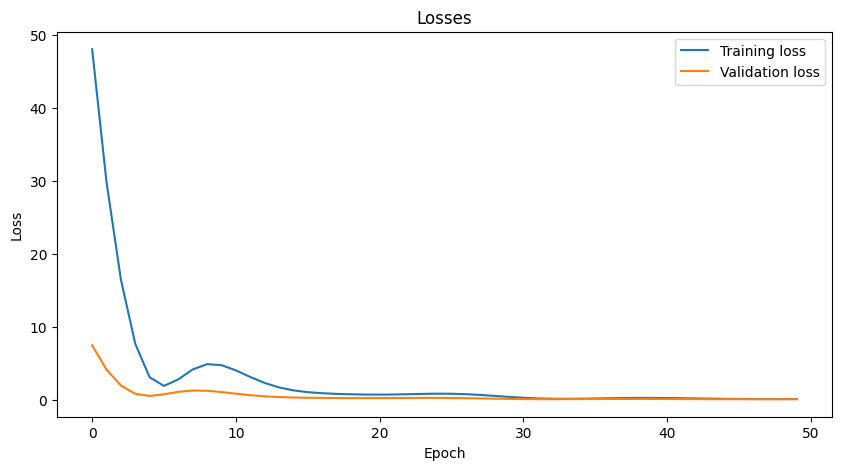

In [93]:
from sklearn.model_selection import train_test_split

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)

import matplotlib.pyplot as plt

# Initialize lists to store losses
train_losses = []
val_losses = []

num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    recon_x, mu, logvar = model(X_train)
    loss = loss_function(recon_x, X_train, mu, logvar)
    loss.backward()
    optimizer.step()
    
    model.eval()
    with torch.no_grad():
        recon_x_val, mu_val, logvar_val = model(X_val)
        val_loss = loss_function(recon_x_val, X_val, mu_val, logvar_val)
    
    # Append losses to the lists
    train_losses.append(loss.item())
    val_losses.append(val_loss.item())
    
    print(f'Epoch {epoch+1}, Loss: {loss.item()}, Val Loss: {val_loss.item()}')

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.title('Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Anomaly Detection

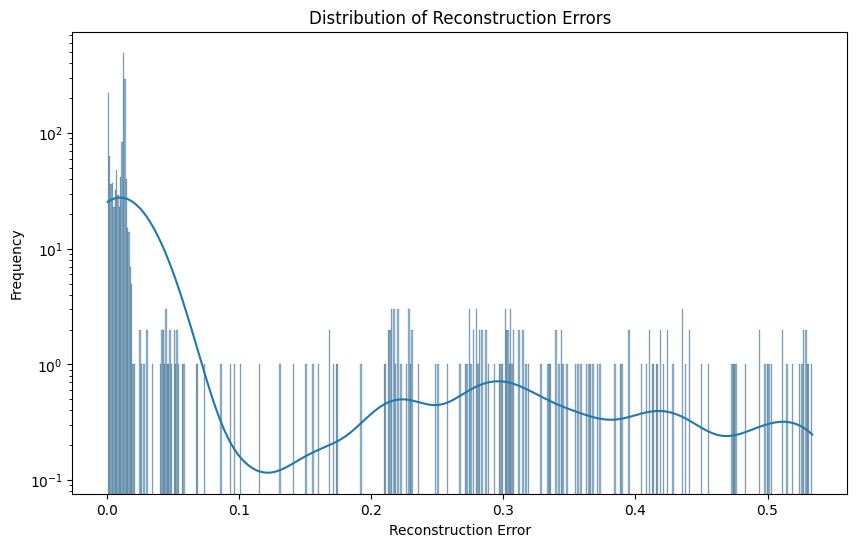

Mean: 0.0397
Median: 0.0122
Standard Deviation: 0.0985

Percentile: 90%
Threshold: 0.0487
Number of anomalies detected: 170


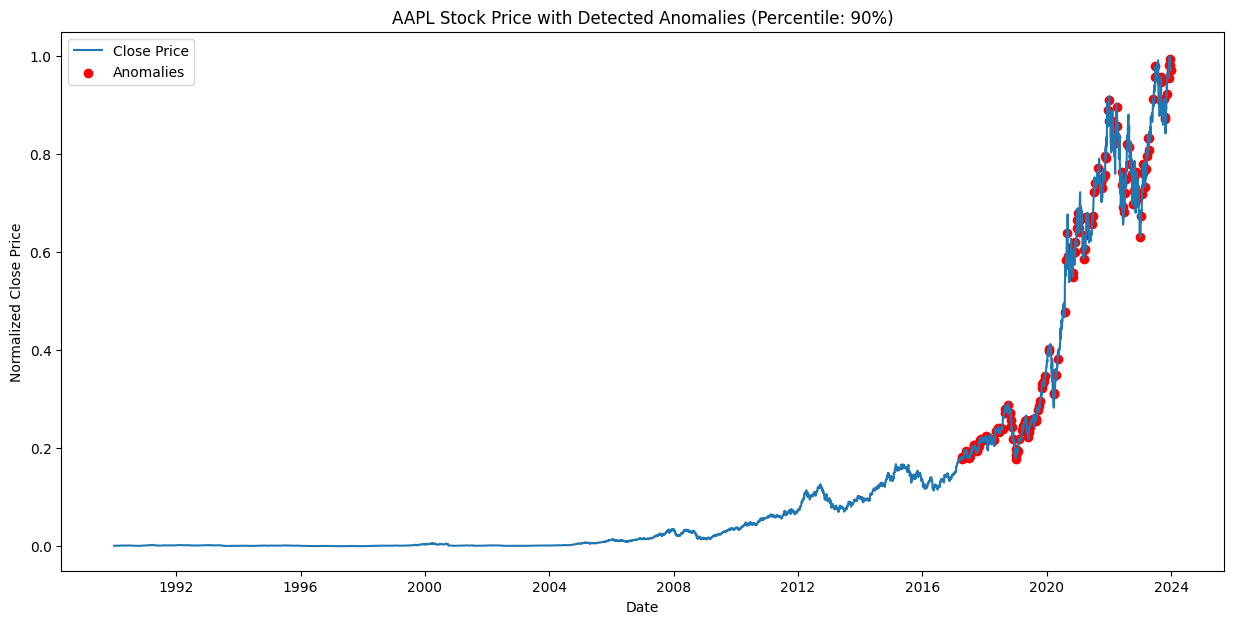


Percentile: 95%
Threshold: 0.3036
Number of anomalies detected: 85


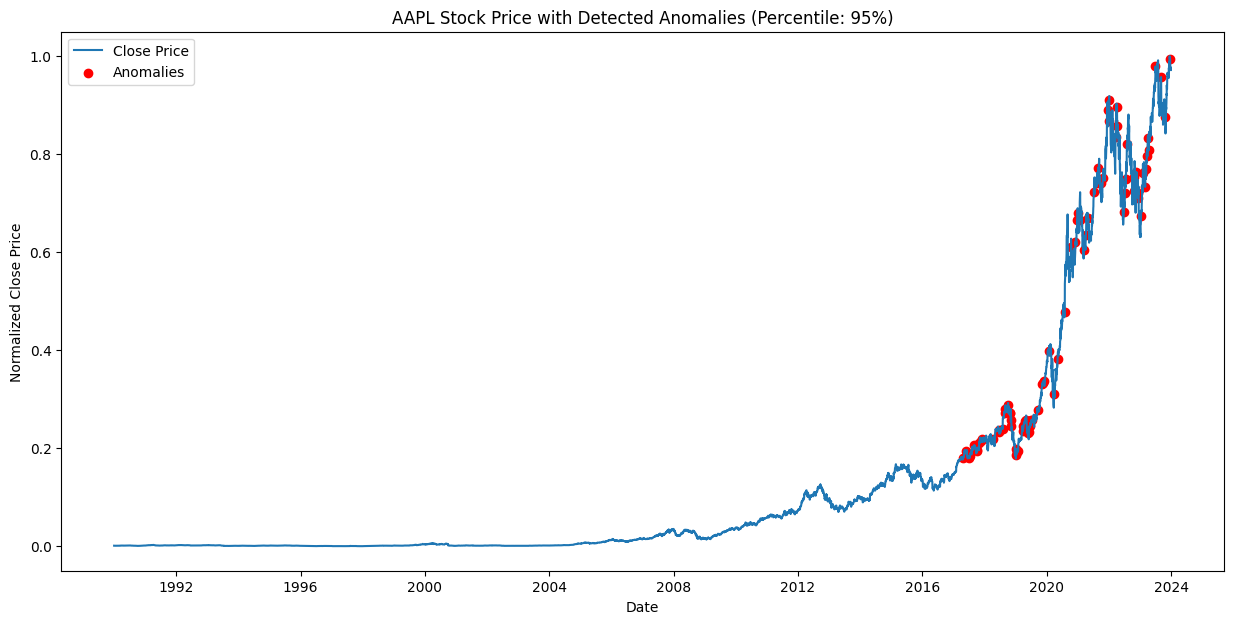


Percentile: 97%
Threshold: 0.3733
Number of anomalies detected: 51


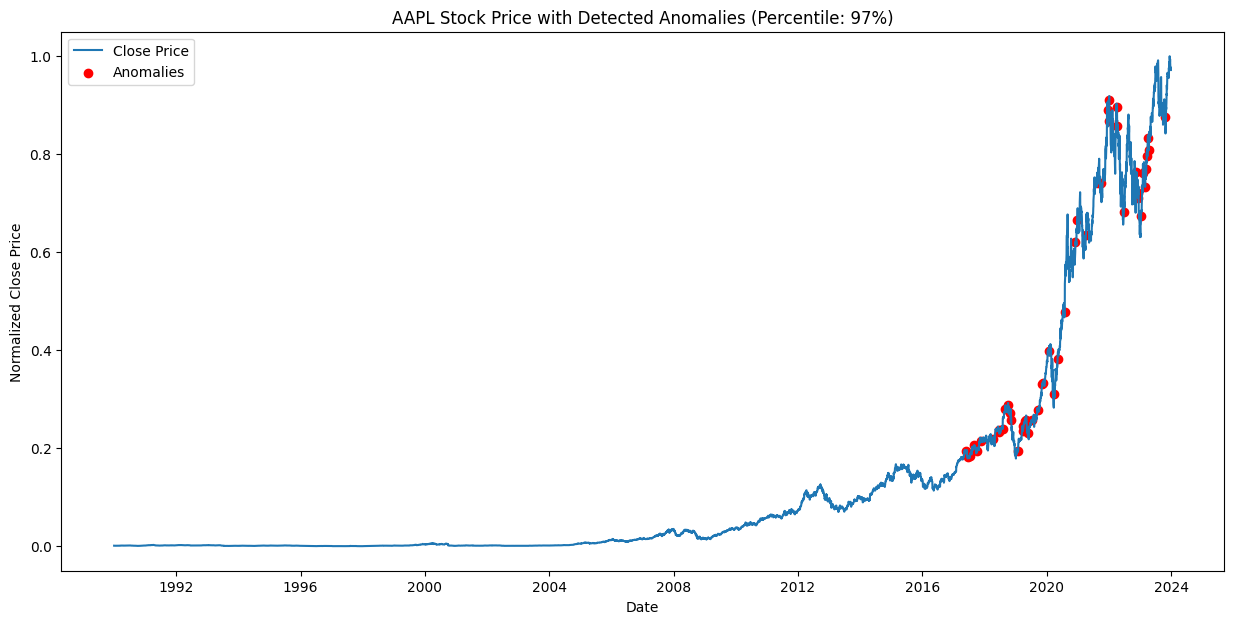


Percentile: 99%
Threshold: 0.4934
Number of anomalies detected: 17


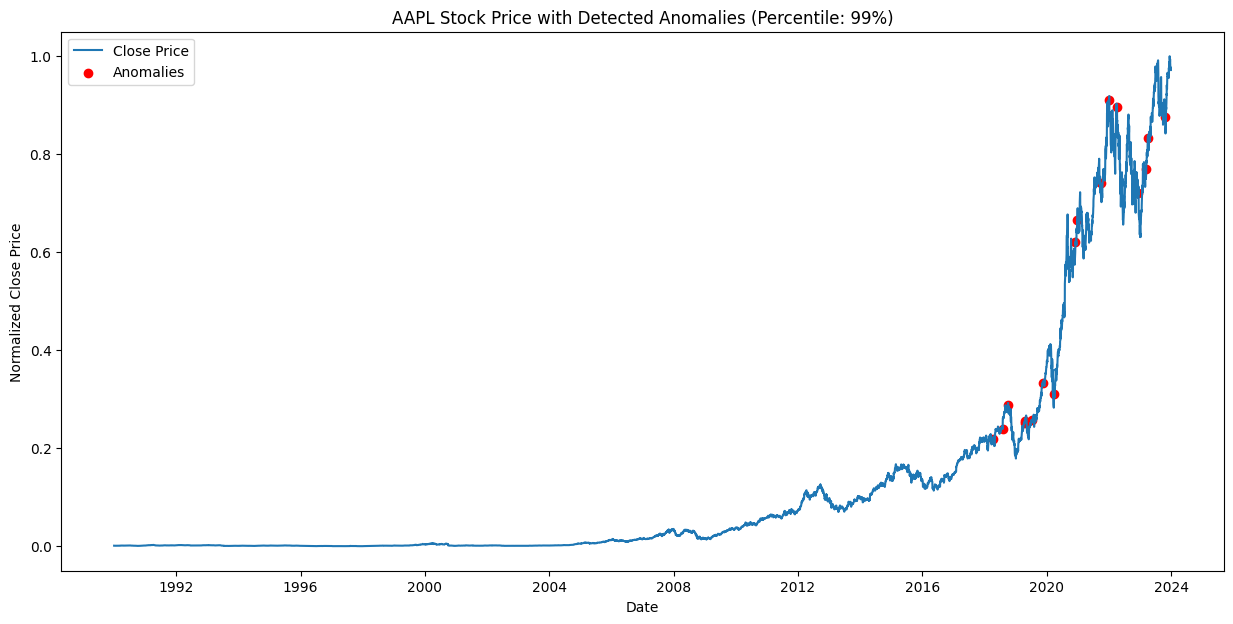


Anomalous date: 2018-04-12 00:00:00
                Open      High       Low     Close    Volume
Date                                                        
2018-04-09  0.214017  0.216310  0.215092  0.214132  0.015322
2018-04-10  0.217958  0.217450  0.217225  0.218173  0.014993
2018-04-11  0.216986  0.217350  0.217441  0.217150  0.011771
2018-04-12  0.218476  0.218703  0.219143  0.219296  0.012017
2018-04-13  0.220207  0.219756  0.220171  0.220041  0.013222
2018-04-16  0.220523  0.220195  0.221416  0.221418  0.011311
2018-04-17  0.222367  0.223641  0.223422  0.224473  0.014021

Anomalous date: 2018-07-30 00:00:00
                Open      High       Low     Close    Volume
Date                                                        
2018-07-25  0.243299  0.243578  0.243763  0.245408  0.008686
2018-07-26  0.245257  0.244969  0.245262  0.244638  0.009962
2018-07-27  0.245737  0.244004  0.240805  0.240560  0.012629
2018-07-30  0.241833  0.240257  0.239497  0.239209  0.011015
2018-07-31 

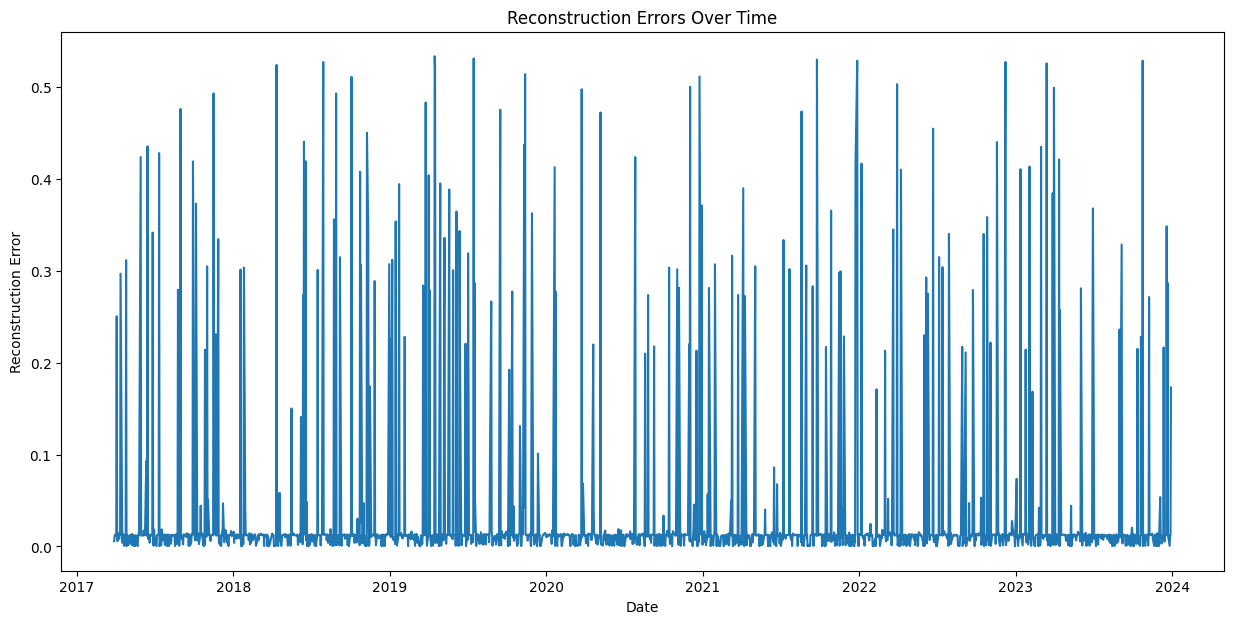

In [97]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Calculate reconstruction errors
model.eval()
with torch.no_grad():
    recon_x, _, _ = model(X_val)
    
# Calculate mean reconstruction error for each sequence
mse_loss = nn.MSELoss(reduction='none')
recon_errors = mse_loss(recon_x, X_val).mean(dim=(1, 2)).numpy()

# Get the correct dates for the validation set
total_sequences = len(X_train) + len(X_val)
val_dates = data_normalized.index[-(len(X_val)):]

# Ensure that val_dates and recon_errors have the same length
assert len(val_dates) == len(recon_errors), "Mismatch between val_dates and recon_errors lengths"

# Plot the distribution of reconstruction errors
plt.figure(figsize=(10, 6))
sns.histplot(recon_errors, kde=True)
plt.yscale('log')
plt.title('Distribution of Reconstruction Errors')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.show()

print(f"Mean: {np.mean(recon_errors):.4f}")
print(f"Median: {np.median(recon_errors):.4f}")
print(f"Standard Deviation: {np.std(recon_errors):.4f}")

# Anomaly detection and visualization
thresholds = [90, 95, 97, 99]
for p in thresholds:
    threshold = np.percentile(recon_errors, p)
    anomalies = recon_errors > threshold
    anomaly_dates = val_dates[anomalies]
    
    print(f"\nPercentile: {p}%")
    print(f"Threshold: {threshold:.4f}")
    print(f"Number of anomalies detected: {len(anomaly_dates)}")
    
    # Plot
    plt.figure(figsize=(15, 7))
    plt.plot(data_normalized.index, data_normalized['Close'], label='Close Price')
    plt.scatter(anomaly_dates, data_normalized.loc[anomaly_dates, 'Close'], color='red', label='Anomalies')
    plt.title(f'AAPL Stock Price with Detected Anomalies (Percentile: {p}%)')
    plt.xlabel('Date')
    plt.ylabel('Normalized Close Price')
    plt.legend()
    plt.show()

# Analyze specific anomalies
for date in anomaly_dates:
    print(f"\nAnomalous date: {date}")
    start_date = max(data_normalized.index[0], date - pd.Timedelta(days=5))
    end_date = min(data_normalized.index[-1], date + pd.Timedelta(days=5))
    print(data_normalized.loc[start_date:end_date, ['Open', 'High', 'Low', 'Close', 'Volume']])

# Plot reconstruction errors over time
plt.figure(figsize=(15, 7))
plt.plot(val_dates, recon_errors)
plt.title('Reconstruction Errors Over Time')
plt.xlabel('Date')
plt.ylabel('Reconstruction Error')
plt.show()

# From 2019-01-01 to 2023-12-31 99th percentile


Percentile: 99%
Threshold: 0.4964
Number of anomalies detected: 17


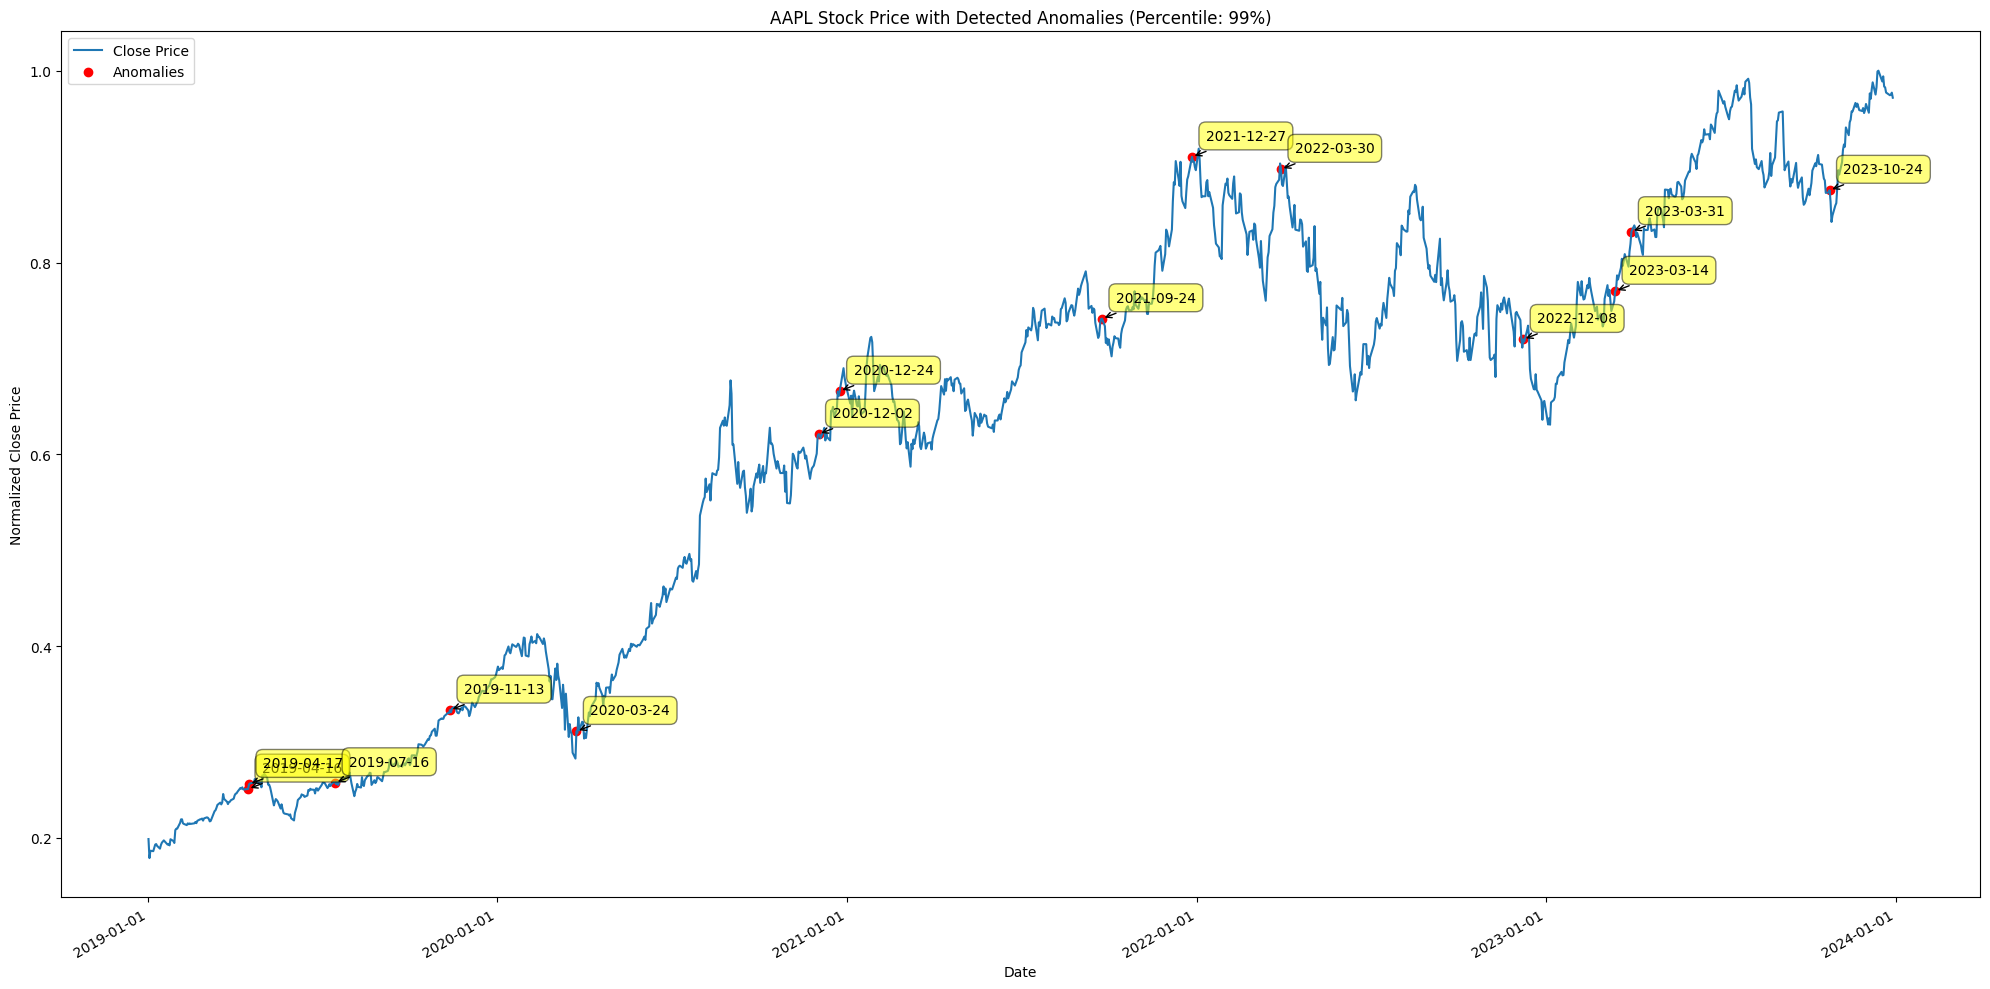


Anomalies detected on the following dates:
2019-04-16
2019-04-17
2019-07-16
2019-11-13
2020-03-24
2020-12-02
2020-12-24
2021-09-24
2021-12-27
2022-03-30
2022-12-08
2023-03-14
2023-03-31
2023-10-24

Anomalous date: 2019-04-16
               Close    Volume
Date                          
2019-04-11  0.250623  0.010945
2019-04-12  0.250522  0.014644
2019-04-15  0.250977  0.009132
2019-04-16  0.251002  0.013531
2019-04-17  0.255901  0.015262
2019-04-18  0.256823  0.012722

Anomalous date: 2019-04-17
               Close    Volume
Date                          
2019-04-12  0.250522  0.014644
2019-04-15  0.250977  0.009132
2019-04-16  0.251002  0.013531
2019-04-17  0.255901  0.015262
2019-04-18  0.256823  0.012722
2019-04-22  0.257669  0.010158

Anomalous date: 2019-07-16
               Close    Volume
Date                          
2019-07-11  0.254159  0.010563
2019-07-12  0.256116  0.009163
2019-07-15  0.258527  0.008814
2019-07-16  0.257631  0.008770
2019-07-17  0.256179  0.007283
2019-

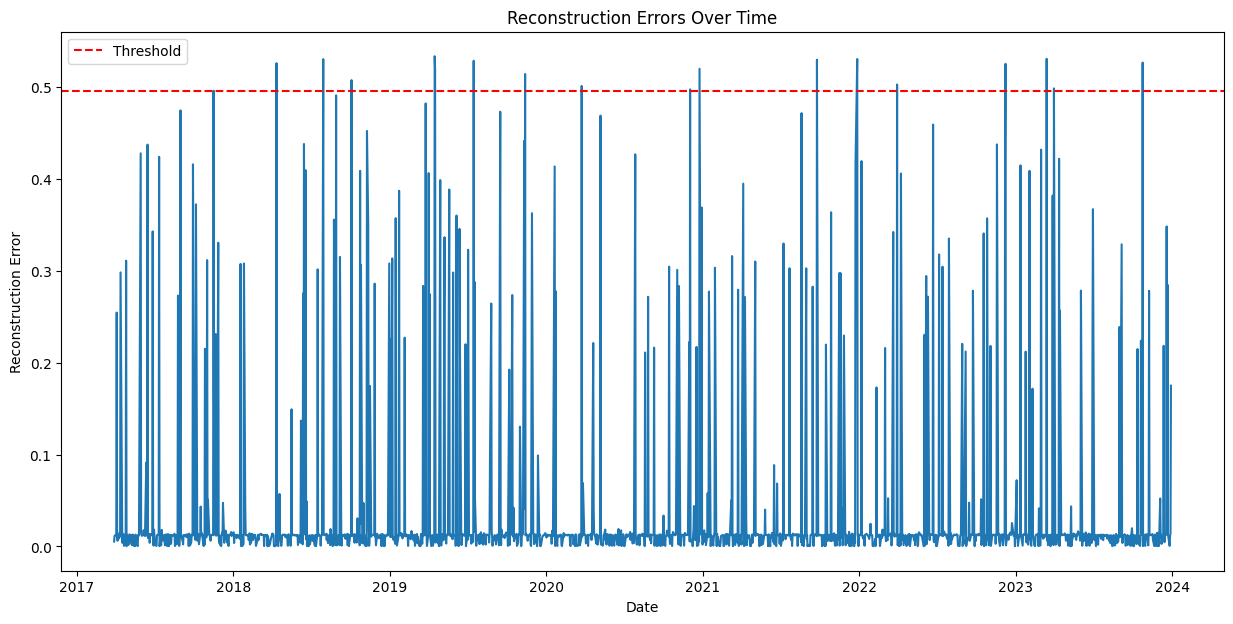

In [95]:
import matplotlib.dates as mdates


# Step 4: Anomaly detection and visualization
p = 99  # Using 99th percentile
threshold = np.percentile(recon_errors, p)
anomalies = recon_errors > threshold
anomaly_dates = val_dates[anomalies]

print(f"\nPercentile: {p}%")
print(f"Threshold: {threshold:.4f}")
print(f"Number of anomalies detected: {len(anomaly_dates)}")

# Plot
plt.figure(figsize=(20, 10))
plot_start = pd.Timestamp('2019-01-01')
plot_end = pd.Timestamp('2023-12-31')

# Filter data for plotting
plot_data = data_normalized[plot_start:plot_end]
plot_anomalies = anomaly_dates[(anomaly_dates >= plot_start) & (anomaly_dates <= plot_end)]

plt.plot(plot_data.index, plot_data['Close'], label='Close Price')
plt.scatter(plot_anomalies, plot_data.loc[plot_anomalies, 'Close'], color='red', label='Anomalies')

# Add date labels for each anomaly
for date in plot_anomalies:
    plt.annotate(date.strftime('%Y-%m-%d'), 
                 (mdates.date2num(date), plot_data.loc[date, 'Close']),
                 xytext=(10, 10), 
                 textcoords='offset points',
                 ha='left',
                 va='bottom',
                 bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
                 arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))

plt.title(f'AAPL Stock Price with Detected Anomalies (Percentile: {p}%)')
plt.xlabel('Date')
plt.ylabel('Normalized Close Price')
plt.legend()

# Improve x-axis date formatting
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gcf().autofmt_xdate()  # Rotation

plt.tight_layout()
plt.show()

# Print anomaly dates
print("\nAnomalies detected on the following dates:")
for date in plot_anomalies:
    print(date.strftime('%Y-%m-%d'))

# Step 5: Analyze specific anomalies
for date in plot_anomalies:
    print(f"\nAnomalous date: {date.strftime('%Y-%m-%d')}")
    start_date = max(plot_start, date - pd.Timedelta(days=5))
    end_date = min(plot_end, date + pd.Timedelta(days=5))
    print(data_normalized.loc[start_date:end_date, ['Close', 'Volume']])

# Step 6: Plot reconstruction errors over time
plt.figure(figsize=(15, 7))
plt.plot(val_dates, recon_errors)
plt.title('Reconstruction Errors Over Time')
plt.xlabel('Date')
plt.ylabel('Reconstruction Error')
plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
plt.legend()
plt.show()

## 95th


Percentile: 95%
Threshold: 0.3035
Number of anomalies detected: 85


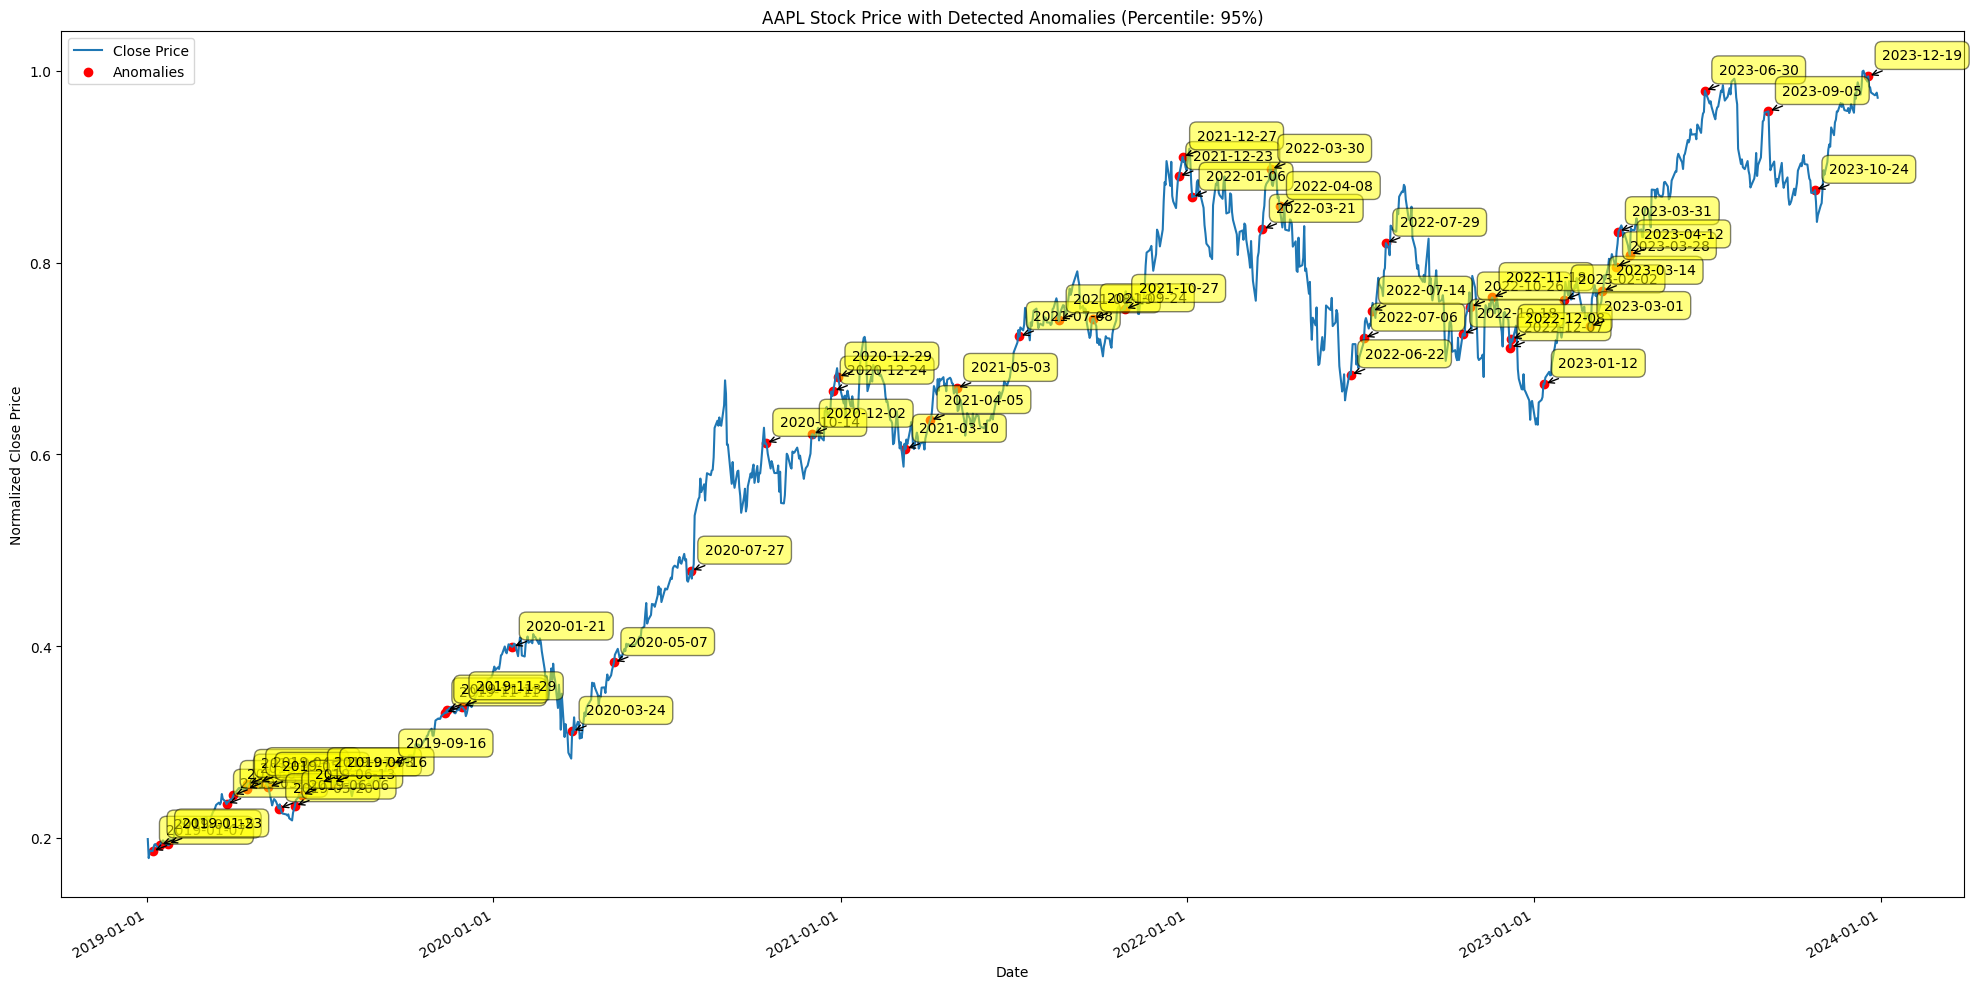


Anomalies detected on the following dates:
2019-01-07
2019-01-15
2019-01-23
2019-03-26
2019-04-02
2019-04-16
2019-04-17
2019-04-29
2019-05-09
2019-05-20
2019-06-06
2019-06-13
2019-07-03
2019-07-16
2019-09-16
2019-11-11
2019-11-13
2019-11-29
2020-01-21
2020-03-24
2020-05-07
2020-07-27
2020-10-14
2020-12-02
2020-12-24
2020-12-29
2021-03-10
2021-04-05
2021-05-03
2021-07-08
2021-08-19
2021-09-24
2021-10-27
2021-12-23
2021-12-27
2022-01-06
2022-03-21
2022-03-30
2022-04-08
2022-06-22
2022-07-06
2022-07-14
2022-07-29
2022-10-18
2022-10-26
2022-11-18
2022-12-07
2022-12-08
2023-01-12
2023-02-02
2023-03-01
2023-03-14
2023-03-28
2023-03-31
2023-04-12
2023-06-30
2023-09-05
2023-10-24
2023-12-19

Anomalous date: 2019-01-07
               Close    Volume
Date                          
2019-01-02  0.198816  0.019646
2019-01-03  0.178954  0.048907
2019-01-04  0.186619  0.031274
2019-01-07  0.186202  0.029210
2019-01-08  0.189763  0.021795
2019-01-09  0.192995  0.023992
2019-01-10  0.193614  0.018968


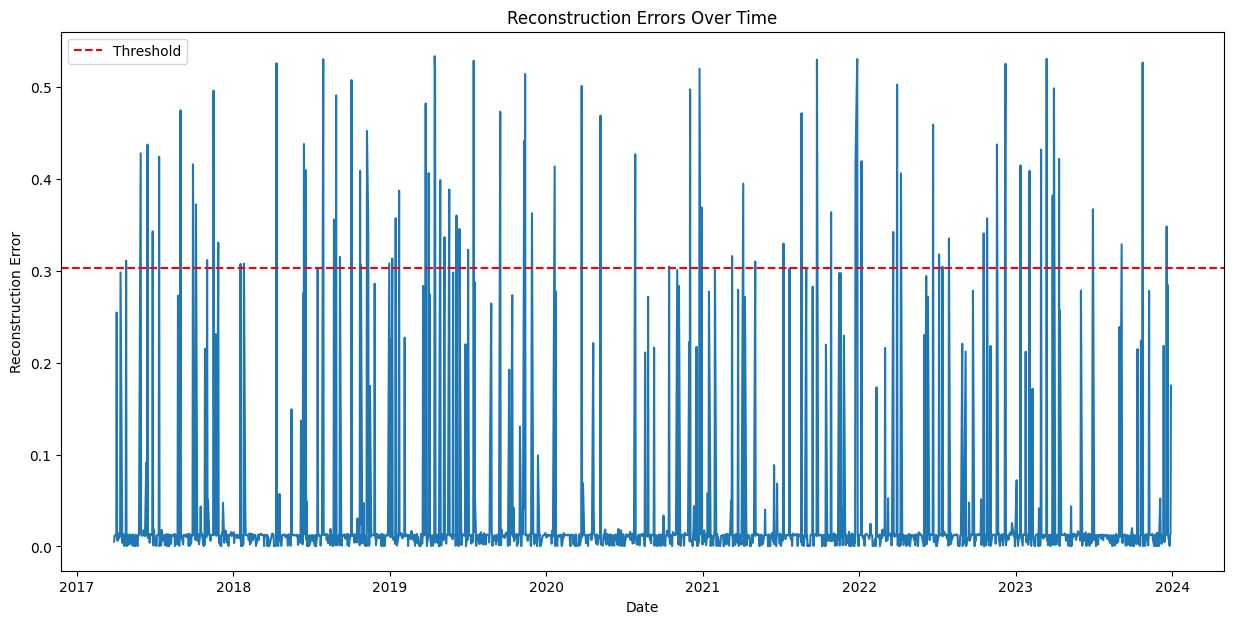

In [96]:
import matplotlib.dates as mdates


# Step 4: Anomaly detection and visualization
p = 95  # Using 99th percentile
threshold = np.percentile(recon_errors, p)
anomalies = recon_errors > threshold
anomaly_dates = val_dates[anomalies]

print(f"\nPercentile: {p}%")
print(f"Threshold: {threshold:.4f}")
print(f"Number of anomalies detected: {len(anomaly_dates)}")

# Plot
plt.figure(figsize=(20, 10))
plot_start = pd.Timestamp('2019-01-01')
plot_end = pd.Timestamp('2023-12-31')

# Filter data for plotting
plot_data = data_normalized[plot_start:plot_end]
plot_anomalies = anomaly_dates[(anomaly_dates >= plot_start) & (anomaly_dates <= plot_end)]

plt.plot(plot_data.index, plot_data['Close'], label='Close Price')
plt.scatter(plot_anomalies, plot_data.loc[plot_anomalies, 'Close'], color='red', label='Anomalies')

# Add date labels for each anomaly
for date in plot_anomalies:
    plt.annotate(date.strftime('%Y-%m-%d'), 
                 (mdates.date2num(date), plot_data.loc[date, 'Close']),
                 xytext=(10, 10), 
                 textcoords='offset points',
                 ha='left',
                 va='bottom',
                 bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
                 arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))

plt.title(f'AAPL Stock Price with Detected Anomalies (Percentile: {p}%)')
plt.xlabel('Date')
plt.ylabel('Normalized Close Price')
plt.legend()

# Improve x-axis date formatting
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gcf().autofmt_xdate()  # Rotation

plt.tight_layout()
plt.show()

# Print anomaly dates
print("\nAnomalies detected on the following dates:")
for date in plot_anomalies:
    print(date.strftime('%Y-%m-%d'))

# Step 5: Analyze specific anomalies
for date in plot_anomalies:
    print(f"\nAnomalous date: {date.strftime('%Y-%m-%d')}")
    start_date = max(plot_start, date - pd.Timedelta(days=5))
    end_date = min(plot_end, date + pd.Timedelta(days=5))
    print(data_normalized.loc[start_date:end_date, ['Close', 'Volume']])

# Step 6: Plot reconstruction errors over time
plt.figure(figsize=(15, 7))
plt.plot(val_dates, recon_errors)
plt.title('Reconstruction Errors Over Time')
plt.xlabel('Date')
plt.ylabel('Reconstruction Error')
plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
plt.legend()
plt.show()

The red dots on the "Close Price with Anomalies" plot indicate the detected anomalies. These are the points where the reconstruction error exceeded the set threshold.

The Threshold for anomaly detection is set based on the mean and standard deviation of the reconstruction error.

- **Compute the Mean Reconstruction Error**: The reconstruction error is calculated for each time stemp in each sequence. To get a single error value for each sequence, we compute the mean reconstruction error across all time steps in the sequence. 

- **Set the Threshold for Anomaly Detection**: The threshold is set to a value above which a sequence is consiered an anomaly. This is done by adding three standard deviations to the mean reconstruction errors. This is based on the assumption that the reconstruction errors follow a normal distribution, and most of the data will lie within three standard deviations of the mean.

- **Identify Anomalies**: Then, we can identify the anomalies by comparing the mean reconstruction errors to the threshold value. If the mean reconstruction error exceeds the threshold, the sequence is considered an anomaly.

**Mean Reconstruction Error (`mean_recon_error`)**: This is the average reconstruction error for each sequence. By averaging the errors, we get a single value that represents the overall error for the sequence.

$$\mu = \text{np.mean}$$

**Threshold**: The threshold is set as three standard deviations above the mean of these mean reconstruction errors. This is a common statistical method for identifying outliers.

**Anomalies**: Any sequence with a mean reconstruction error above this threshold is marked as anomaly.

______

This code implements a comprehensive anomaly detection process using the reconstruction errors from the VAELSTM model. Let's break it down step by step:

- **Calculate Reconstruction Errors**:
    - The trained model is used to reconstruct the validation data.
    - Mean Squared Error (MSE) is calculated between the original and reconstructed data for each sequence.

- **Date Alignment**:
    - The code ensures that the dates for the validation set are correctly aligned with the reconstruction errors.

- **Visualization of Error Distribution**:
    - A histogram of reconstruction errors is plotted to show their distribution.
    - Basic statistics (mean, median, standard deviation) of the errors are printed.

- **Anomaly Detection and Visualization**:
    - Multiple thresholds (90th, 95th, 97th, and 99th percentiles) are used to detect anomalies.
    - For each threshold:
        - Anomalies are identified as points with errors above the threshold.
        - The number of detected anomalies is printed.
        - A plot is generated showing the stock price with anomalies highlighted.

- **Detailed Anomaly Analysis**:
    - For each detected anomaly (using the highest threshold):
        - The date of the anomaly is printed.
        - Data for 5 days before and after the anomaly is displayed, showing 'Close' price and 'Volume'.

- **Temporal View of Reconstruction Errors**:
    - A plot of reconstruction errors over time is generated, allowing visualization of how errors change across the validation period.


### Key Aspects of this Approach:

1. Multi-threshold Analysis: By using multiple percentile thresholds, the code provides a sensitivity analysis of anomaly detection.
2. Contextual Information: The analysis of data around anomalous dates helps in understanding the context of each anomaly.
3. Visual and Numerical Insights: The approach combines visual plots with numerical data, offering a comprehensive view of the anomalies.
4. Time Series Perspective: By plotting errors over time, it's possible to identify periods with consistently high reconstruction errors.
5. Normalized Data: The use of normalized data ensures that the anomaly detection is not biased by the scale of the original values.

### Interpretation and Use:

- Anomalies detected at higher percentiles (e.g., 99th) are likely to be more significant or rare events.
- The contextual analysis around anomalies can help in understanding whether these are genuine anomalies or false positives.
- The temporal plot of errors can reveal periods of increased volatility or unusual market behavior.

This approach provides a thorough examination of potential anomalies in the stock price data, allowing for both broad pattern recognition and detailed investigation of specific anomalous events.

_______

Plot anomalies for a specific Time Period

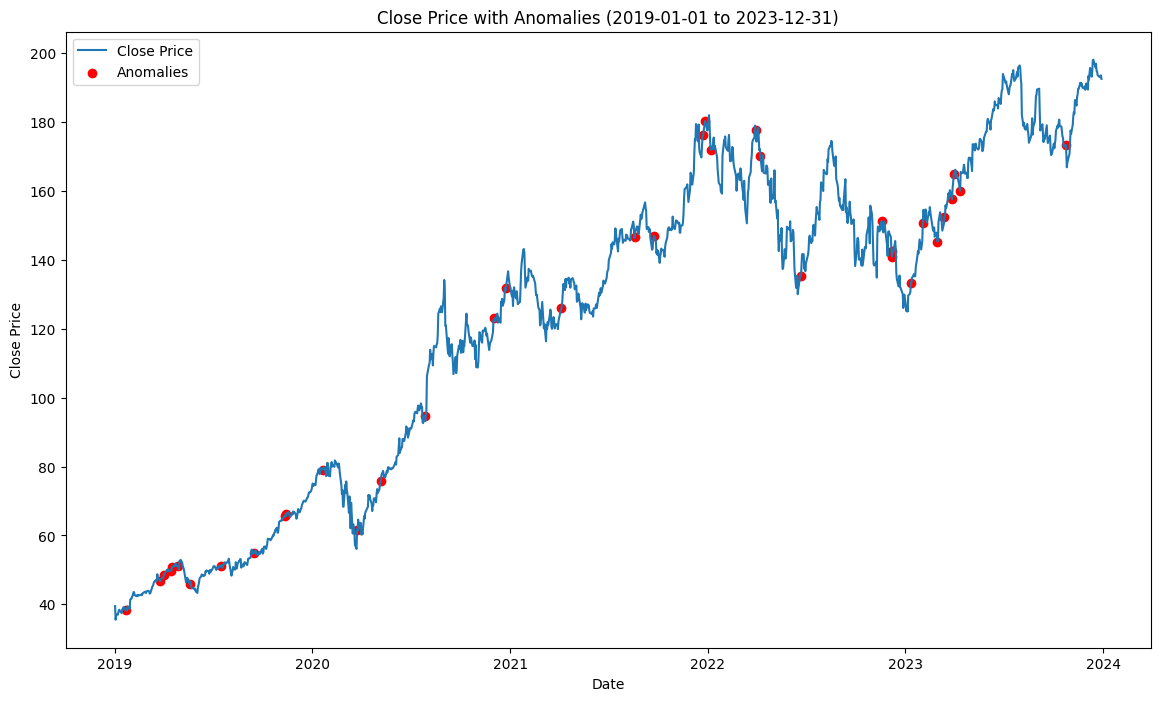

In [69]:
# Filter the data for the specific period
start_date = '2019-01-01'
end_date = '2023-12-31'

filtered_dates = (val_dates >= start_date) & (val_dates <= end_date)
filtered_val_dates = val_dates[filtered_dates]
filtered_anomalies = anomalies[filtered_dates]
filtered_close_prices = data_selected['Close'].loc[start_date:end_date]

# Plot the Close price with anomalies for the specific period
plt.figure(figsize=(14, 8))
plt.plot(filtered_close_prices.index, filtered_close_prices, label='Close Price')
plt.scatter(filtered_val_dates[filtered_anomalies], filtered_close_prices.iloc[-len(filtered_val_dates):].iloc[filtered_anomalies], color='red', label='Anomalies')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title(f'Close Price with Anomalies ({start_date} to {end_date})')
plt.legend()
plt.show()


In [70]:
# \Print each dates with anomalies from 2019-01-01 to 2023-12-31 
anomaly_dates = filtered_val_dates[filtered_anomalies]
print(anomaly_dates)




DatetimeIndex(['2019-01-23', '2019-03-26', '2019-04-02', '2019-04-16',
               '2019-04-17', '2019-04-29', '2019-05-20', '2019-07-16',
               '2019-09-16', '2019-11-11', '2019-11-13', '2020-01-21',
               '2020-03-24', '2020-05-07', '2020-07-27', '2020-12-02',
               '2020-12-24', '2021-04-05', '2021-08-19', '2021-09-24',
               '2021-12-23', '2021-12-27', '2022-01-06', '2022-03-30',
               '2022-04-08', '2022-06-22', '2022-11-18', '2022-12-07',
               '2022-12-08', '2023-01-12', '2023-02-02', '2023-03-01',
               '2023-03-14', '2023-03-28', '2023-03-31', '2023-04-12',
               '2023-10-24'],
              dtype='datetime64[ns]', name='Date', freq=None)


____

In [72]:
# Extract the dates of the anomalies
anomaly_dates = filtered_val_dates[filtered_anomalies]

# Print the dates of the anomalies
print("Dates of the anomalies from 2019-01-01 to 2023-12-31:")
print(anomaly_dates)

Dates of the anomalies from 2019-01-01 to 2023-12-31:
DatetimeIndex(['2019-01-23', '2019-03-26', '2019-04-02', '2019-04-16',
               '2019-04-17', '2019-04-29', '2019-05-20', '2019-07-16',
               '2019-09-16', '2019-11-11', '2019-11-13', '2020-01-21',
               '2020-03-24', '2020-05-07', '2020-07-27', '2020-12-02',
               '2020-12-24', '2021-04-05', '2021-08-19', '2021-09-24',
               '2021-12-23', '2021-12-27', '2022-01-06', '2022-03-30',
               '2022-04-08', '2022-06-22', '2022-11-18', '2022-12-07',
               '2022-12-08', '2023-01-12', '2023-02-02', '2023-03-01',
               '2023-03-14', '2023-03-28', '2023-03-31', '2023-04-12',
               '2023-10-24'],
              dtype='datetime64[ns]', name='Date', freq=None)


Visualizing the latent space can help us understand how well the model has learned to represent the data. It can also help in identifying clusters and structures in the data, which may correspond to different patterns or anomalies. This can be helpful for:

- **Understanding Data Representation**: By visualizing the latent space, we can see how the VAE encodes the input data into a lower-dimensional space. This can provide insights into the underlying structure of the data.

- **Identifying Clusters**: Clusters in the latent space may correspond to different behaviors or regimes in the data. For example, different clusters might represent different market conditions or types of anomalies.

- **Model Evaluation**: A well-structured latent space indicates that the VAE has effectively learned the data distribution. Poorly structured latent space might suggest issues with model training or architecture.

To visualize the latent space, we can follow these steps:

1. **Extract Latent Vectors**: Pass the data through the encoder to get the mean ($\mu$) vectors representing the latent space.

2. **Dimensionality Reduction**: If the latent space has more than two dimensions, use techniques like t-SNE or PCA to reduce it to two dimensions for plotting.

3. **Plot the Latent Space**: Plot the 2D representation of the latent vectors. Color the points based on some criteria (e.g., whether they are anomalies). It's possible also plot the 3D representation of the latent vectors using a 3D scatter plot.

Points with higher reconstruction error (potential anomalies) will be highlighted, helping to understand the distribution and structure of the data in the latent space.


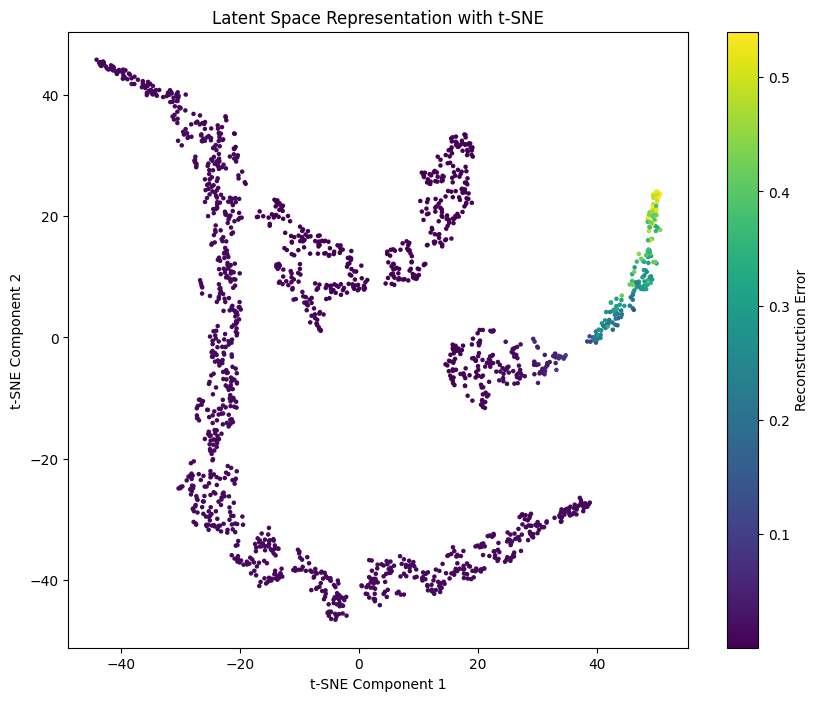

In [98]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Function to extract latent vectors (mu) from the encoder
def get_latent_vectors(model, data):
    model.eval()
    with torch.no_grad():
        mu, logvar = model.encode(data)
    return mu

# Extract latent vectors for the validation set
latent_vectors = get_latent_vectors(model, X_val).numpy()

# Use t-SNE to reduce dimensionality to 2D
tsne = TSNE(n_components=2, random_state=42)
latent_2d = tsne.fit_transform(latent_vectors)

# Plot the latent space
plt.figure(figsize=(10, 8))
plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=mean_recon_error, cmap='viridis', s=5)
plt.colorbar(label='Reconstruction Error')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('Latent Space Representation with t-SNE')
plt.show()


The t-SNE plot of the latent space representation shows how the VAE has encoded the input data into a lower-dimensional space. The color gradient represents the reconstruction error, with higher values indicating potential anomalies. 

The presence of distinct clusters in the latent space suggests that the VAE has learned to group similar sequences together. The points with higher reconstruction errors (shown in lighter colors) could correspond to anomalies. These points are more likely to be outliers or unusual sequences that the model struggles to recontruct accurately.

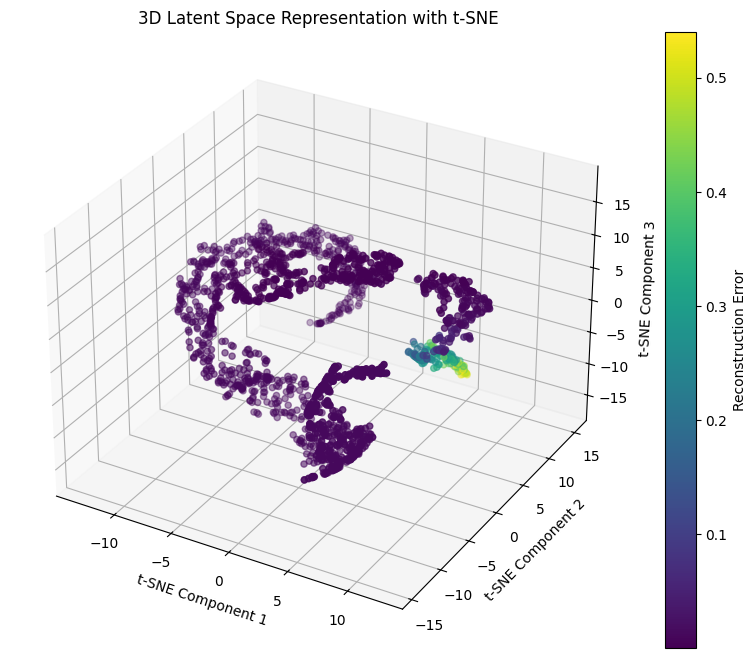

In [99]:
from mpl_toolkits.mplot3d import Axes3D

# Use t-SNE to reduce dimensionality to 3D
tsne = TSNE(n_components=3, random_state=42)
latent_3d = tsne.fit_transform(latent_vectors)

# Create a 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
p = ax.scatter(latent_3d[:, 0], latent_3d[:, 1], latent_3d[:, 2], c=mean_recon_error, cmap='viridis')
fig.colorbar(p, ax=ax, label='Reconstruction Error')

ax.set_xlabel('t-SNE Component 1')
ax.set_ylabel('t-SNE Component 2')
ax.set_zlabel('t-SNE Component 3')
plt.title('3D Latent Space Representation with t-SNE')
plt.show()

### Analysis from the plots

The plot shows three t-SNE components (Component 1, Component 2, Component 3), which are the reduced dimensions derived from the original latent space. The color bar represents the mean reconstruction error, where different colors indicate the level of error. Higher values suggest higher recontruction errors, potentially indicating anomalies. 

From the plot we can observe clusters of data points. These clusters represent normal behavior in the stock prices of AAPL stock market. Points with colors towards the yellow end of the spectrum indicate higher reconstruction errors, suggesting anomalies or unusual behaviors in stock prices.

In this plot, each point represents a stock price data point for AAPL that has been encoded into a latent space by the VAE-LSTM model. The t-SNE algorithm then reduces this latent space to three dimensions for visualization purpose.

- **Clusters of Purple Points**: These represent normal data points where the reconstruction error is low, indicating that the model ha accurately reconstructed these points from the latent space.
- **Yellow and green points**: These represent anomalies where the reconstruction error is higher. These points are not well-reconstructed by the model, suggesting unusual or abnormal patterns in the stock prices.

____